In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
import copy
from itertools import combinations
import numba
from numba import prange

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve

from sklearn.metrics import plot_precision_recall_curve

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier 
from xgboost import XGBClassifier
import umap
import umap.plot

from imblearn import FunctionSampler
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline 
import smote_variants as sv 

from category_encoders import CatBoostEncoder
from category_encoders import GLMMEncoder
from category_encoders import OrdinalEncoder

import pydotplus 
from IPython.display import Image
import graphviz

from dython.nominal import associations
import arfs.allrelevant as arfsgroot
from mlxtend.feature_selection import ColumnSelector
from mlxtend.evaluate import combined_ftest_5x2cv

import missingno as msno
from missingpy import MissForest


from ray import tune
from tune_sklearn import TuneSearchCV
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('max_colwidth', None)
pd.set_option('max_rows', None)

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.


In [2]:
def print_value_counts(dataframe):
    
    for column in dataframe:        
        if dataframe[column].dtype == object:
            print(dataframe[column].value_counts())
            print('')
            
        else:
            print(dataframe[column].value_counts().sort_index()) 
            print('')
            

def print_data_plots(dataframe):
    
    columns_countplot = [column for column in dataframe.columns if dataframe[column].nunique() < 80]
    columns_distplot = [column for column in dataframe.columns if dataframe[column].nunique() > 80]
    fig_dims = (13,4)    
    
    for column in dataframe[columns_countplot].columns:
        plt.figure()
        fig, ax = plt.subplots(figsize=fig_dims) 
        fig.autofmt_xdate()
        sns.countplot(x=column, data=dataframe)
        
    for column in dataframe[columns_distplot].columns:
        plt.figure()
        fig, ax = plt.subplots(figsize=fig_dims) 
        fig.autofmt_xdate()
        sns.histplot(dataframe[column])


# В  из библиотеки category_encoders был баг,
# кроме того, он не был адоптирован для использования в пайплайнах
# я переписпал его

class NestedCVWrapper(BaseEstimator, TransformerMixin):

    """Wrapper для вложенной кросс-валидации для целевых категориальных кодировщиков.
    Позволяет провести Single Validation из 
    https://towardsdatascience.com/benchmarking-categorical-encoders-9c322bd77ee8.       
    """
    
    def __init__(self, feature_encoder, cv=5, shuffle=True, random_state=None):
        self.feature_encoder = feature_encoder
        self.__name__ = feature_encoder.__class__.__name__
        self.model_list = []
        self.trn_idx_list = []
        self.oof_idx_list = []
        self.len_train = 0

        if type(cv) == int:
            self.cv = StratifiedKFold(n_splits=cv, shuffle=shuffle, random_state=random_state)
        else:
            self.cv = cv

    def fit(self, X, y, **kwargs):        
        self.len_train = X.shape[0]        
        for trn_idx, oof_idx in self.cv.split(X, y):
            feature_encoder = copy.deepcopy(self.feature_encoder)
            self.model_list.append(feature_encoder.fit(X.iloc[trn_idx], y.iloc[trn_idx]))
            self.trn_idx_list.append(trn_idx)
            self.oof_idx_list.append(oof_idx)
        
        self.feature_encoder.fit(X, y)       
            
        return self


    def transform(self, X):
        
        if self.len_train == X.shape[0]:
            out_of_fold = np.zeros(X.shape)
            for model, trn_idx, oof_idx in zip (self.model_list, self.trn_idx_list, self.oof_idx_list):
                out_of_fold[oof_idx] = model.transform(X.iloc[oof_idx])
            out_of_fold = pd.DataFrame(out_of_fold, columns=X.columns)   
            
            return out_of_fold
        else:
            
            return self.feature_encoder.transform(X)

        
# функция из imbalanced-learn для использования IsolationForest в пайплайне
def reject_outliers(X, y, contamination=0.01):
    
    model = IsolationForest(contamination=contamination, random_state=SEED, n_jobs=-1)
    model.fit(X)
    y_pred = model.predict(X)
    
    return X[y_pred == 1], y[y_pred == 1]


# модифицировнная функция, в которой выбросы удаляются только из мажоритарного отрицательного класса
def reject_neg_class_outliers(X, y, contamination=0.01, n_estimators=100, max_samples='auto'):
    
    model = IsolationForest(contamination=contamination, n_estimators=n_estimators, 
                            max_samples=max_samples, random_state=SEED, n_jobs=-1)
    model.fit(X) 
    y_pred = model.predict(X)    
    
    return X[np.any([y == 1, y_pred == 1], axis=0)], y[np.any([y == 1, y_pred == 1], axis=0)]


def calculate_vif(features):
    
    # добавляем фиктивную переменную для расчёта правильных значений VIF
    features = features.assign(const=1)    
    vif = pd.DataFrame()
    vif["variables"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

    return(vif)


# рассчитываем коэффициента eta, который является мерой силы связи 
# между категориальными и количественными признаками
def calculate_eta_corr(dataframe, quant_features, cat_features):
    quant_eta_lists = []
    
    for quant_feature in quant_features:
        eta_list = []
        
        for cat_feature in cat_features:        
            model = ols('{} ~ C({})'.format(quant_feature, cat_feature), data=dataframe).fit()
            anova_table = sm.stats.anova_lm(model, typ=2, robust='hc3') 
            eta = anova_table[:-1]['sum_sq']/sum(anova_table['sum_sq'])             
            eta_list.append(float(eta))            
        quant_eta_lists.append(eta_list)   
        
    return pd.DataFrame(quant_eta_lists, columns=cat_features, index=quant_features)


def get_high_corr_features(corr_matrix, threashold, fill_diagonal_ones = True):
    
    corr_matrix_abs = corr_matrix.abs()
    if fill_diagonal_ones == True:
        np.fill_diagonal(corr_matrix_abs.values, 0)    
    # создаем список признаков с корреляцией больше порога
    high_corr_features = [column for column in corr_matrix_abs.columns
                          if any(corr_matrix_abs[column] > threashold)]
    
    return high_corr_features


def get_indexes_features(dataframe, features):
    indexes = [dataframe.columns.get_loc(feature) for feature in features]
    return indexes


def get_all_combinations(corr_indexes, empty_combination = False):
    tuple_combinations = []
    end_in_range = len(corr_indexes)+1
    
    if empty_combination == True:
        first_in_range = 0
    else:
        first_in_range = 1      
    
    for length_combination in range(first_in_range, end_in_range):
        tuple_combinations += list(combinations(corr_indexes, length_combination))
    list_combinations = [list(element) for element in tuple_combinations]
    
    return list_combinations


# получаем комбинации важных функций с неважными
def get_imp_unimp_combinations(unimp_combinations, imp_combination):    
    imp_unimp_combinations = []  
    
    for unimp_combination in unimp_combinations:    
           imp_unimp_combinations.append(unimp_combination + imp_combination)
            
    return imp_unimp_combinations


def get_grid_result(gridsearch_name):    
    result = (
        pd.DataFrame({
            'mean_average_precision': gridsearch_name.cv_results_['mean_test_average_precision'],
            'mean_roc_auc': gridsearch_name.cv_results_['mean_test_roc_auc']}).join(
        pd.json_normalize(gridsearch_name.cv_results_['params']).add_prefix('param_'))
    ).sort_values(['mean_average_precision'], ascending = False)
         
    return result

In [3]:
SEED = 42

In [4]:
df = pd.read_csv('./bank-additional-full.csv', sep = ';')
# заменяем точки на нижнее подчеркивание в названиях признаков
df = df.rename(columns=dict(zip(df.columns, list(map(lambda x: x.replace('.', '_'), df.columns)))))

In [5]:
df.head(5) 

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
df.shape

(41188, 21)

In [7]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [8]:
df.describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [9]:
list_cat_features = df.select_dtypes(include = object).columns.to_list()

In [1]:
print_value_counts(df)
""" Вместо NaN используется unknown,
есть очень редкие категории,
экстремальные значения/выбросы,
категориальные признаки с двумя значениями стоит кодировать в 1, 0,
отсуствуют странные, некорректные уникальные значения,
в датасете дисбаланс классов.
"""

In [11]:
pd.set_option('max_columns', None)
# отображаем количество уникальных значений у каждого признака
df.agg(['nunique'])

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
nunique,78,12,4,8,3,3,3,2,10,5,1544,42,27,8,3,10,26,26,316,11,2


In [2]:
print_data_plots(df)       

In [13]:
df.drop_duplicates(inplace=True)
# удаляем объекты с очень редкой категорией 18 из 41188
df = df[df.education != 'illiterate']
# удаляем признак duration, чтобы избежать утечки данных 
# (как сказано в документации к датасету)
df.drop('duration', axis=1, inplace=True)
df.reset_index(drop=True)
# объединим 'unknown' и 'yes', чтобы избавиться от редкой категории
# и закодируем 'default' как бинарный признак
df['default'] = (df['default'] != 'no').astype(int)
# всех клиентов, с которыми связывались хотя бы раз объединяем под категорией 1,
# остальных под категорией 0
df['pdays'] = (df['pdays'] != 999).astype(int)
# кодируем порядковые и бинарные признаки
# исходя из информации о системе образования в Португалии,
# уровни образования следует упордочить следующим образом
df.replace(
    {'basic.4y': 1, 'basic.6y': 2, 'basic.9y': 3,'professional.course': 4,
    'high.school': 5, 'university.degree' : 6, 'yes': 1, 'no': 0, 
    'cellular': 1, 'telephone': 0,'mar': 1, 'apr': 2, 'may': 3, 'jun': 4, 
    'jul': 5, 'aug': 6, 'sep': 7, 'oct': 8, 'nov': 9, 'dec': 10, 'mon': 1,
    'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5}, inplace=True
)                 

In [14]:
df_NaN = df.replace('unknown', np.NaN)
df_NaN.isna().sum()

age                  0
job                330
marital             80
education         1730
default              0
housing            990
loan               990
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp_var_rate         0
cons_price_idx       0
cons_conf_idx        0
euribor3m            0
nr_employed          0
y                    0
dtype: int64

In [15]:
msno.matrix(df_NaN, figsize=(10, 6))

<AxesSubplot:>

<AxesSubplot:>

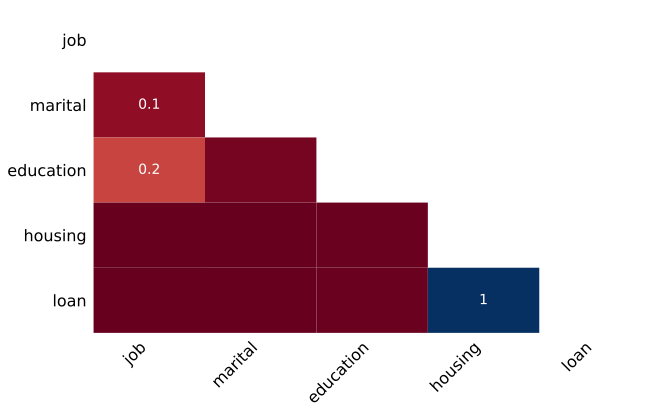

In [16]:
# пропуски в housing и loan у одних и тех же объектов
msno.heatmap(df_NaN, figsize = (10,6))

In [17]:
dataframe_X = df_NaN.loc[:, df_NaN.columns != 'y']
series_y = df_NaN.y
# создаем списки c названиями признаков по типам признаков
nominal = list(dataframe_X.select_dtypes(include = object).columns)

binary = [dataframe_X[column].name for column in dataframe_X.columns 
          if dataframe_X[column].nunique() == 2]

ordinal = [dataframe_X[column].name for column in dataframe_X.columns 
           if (dataframe_X[column].name in list_cat_features 
           and 3 in dataframe_X[column].unique())]

cat = nominal + ordinal + binary 

quantitative = [dataframe_X[column].name for column in dataframe_X.columns 
            if dataframe_X[column].name not in cat]

ord_bin = ordinal + binary
quant_ord = quantitative + ordinal
quant_nom = quantitative + nominal

# получаем список индексов, указывающих на порядковые и бинарные признаки с пропусками,
# для передачи его в MissForest
ord_bin_nan = dataframe_X[ord_bin].columns[dataframe_X[ord_bin].isnull().any()].tolist()
ord_bin_nan_indexes = [dataframe_X.columns.get_loc(column) for column in ord_bin_nan]

# переносим признак 'poutcome' из ord_bin в quant_nom,
# ввиду особеностей масштабирования в дальнейшем 
ord_bin_w_pout = copy.deepcopy(ord_bin) + ['poutcome'] 
quant_nom_wo_pout = copy.deepcopy(quant_nom)
quant_nom_wo_pout.remove('poutcome')
scaler_columns = quant_nom_wo_pout+ord_bin_w_pout
# получаем индексы признаков для передачи в ColumnTransformer
ord_bin_w_pout_indexes = [dataframe_X.columns.get_loc(column) for column in ord_bin_w_pout] 
quant_nom_wo_pout_indexes = [dataframe_X.columns.get_loc(column) for column in quant_nom_wo_pout]

Scaler = ColumnTransformer([
        ('quant_nom', RobustScaler(), quant_nom_wo_pout_indexes),
        ('ord_bin', MinMaxScaler(feature_range=(-1, 1)), ord_bin_w_pout_indexes)
])

print(quantitative)
print(nominal)
print(binary)
print(ordinal)
print(ord_bin_w_pout)
print(quant_nom_wo_pout)
print(ord_bin_nan_indexes)

['age', 'campaign', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
['job', 'marital', 'poutcome']
['default', 'housing', 'loan', 'contact', 'pdays']
['education', 'month', 'day_of_week']
['education', 'month', 'day_of_week', 'default', 'housing', 'loan', 'contact', 'pdays', 'poutcome']
['age', 'campaign', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'job', 'marital']
[3, 5, 6]


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
df_NaN.loc[:, df_NaN.columns != 'y'], df_NaN.y, stratify=df_NaN.y, test_size=0.15, random_state=SEED)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [19]:
# предобрабатываем данные для разведочного анализа
pipe_eda = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED)), 
    ('scaler', Scaler)
    ])

X_train_eda = pipe_eda.fit_transform(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes) 
X_train_eda = pd.DataFrame(X_train_eda, columns=scaler_columns)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


In [20]:
train_eda = pd.concat([X_train_eda, y_train], axis=1)
# детектируем выбросы, чтобы далее без них точнее рассчитать корреляцию признаков
Iso_Forest = IsolationForest(random_state=SEED, contamination='auto', n_estimators=200)
Iso_Forest.fit(X_train_eda)
# предсказываем выбросы в автоматическом режиме
label_outliers_auto = Iso_Forest.predict(X_train_eda) 
label_outliers_auto = pd.Series(label_outliers_auto, name='label_outliers_auto', index=(X_train_eda.index))
# посмотрим сколько выбросов нам предсказал алгоритм в автоматическом режиме
print(label_outliers_auto.value_counts())

 1    23683
-1    11301
Name: label_outliers_auto, dtype: int64


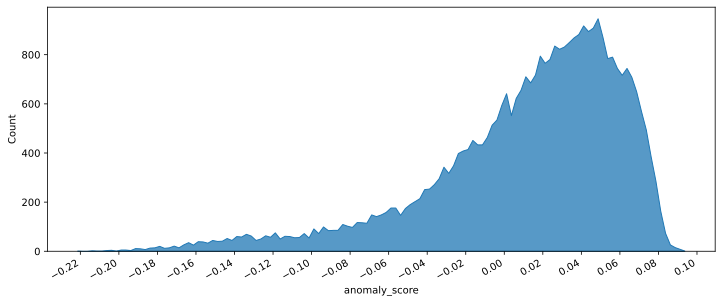

In [21]:
# в авто режиме алгоритм отнёс 1/3 к выбросам,
# поэтому мы сами определим threshold для выбросов по anomaly_score
# чем ментьше anomaly_score, тем вероятней объект является выбросом
anomaly_score = Iso_Forest.decision_function(X_train_eda)
anomaly_score = pd.Series(anomaly_score, name='anomaly_score',
                          index=X_train_eda.index)

fig_dims = (12,5) 
fig, ax = plt.subplots(figsize=fig_dims)        
fig.autofmt_xdate()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
sns.histplot(anomaly_score, binwidth=0.0025, element='poly')

outlier_threshold = -0.10

In [22]:
df_umap = train_eda.copy()
# помечаем выбросы для визуализации вместе с метками классов в umap
df_class_w_outliers = df_umap.copy()
df_class_w_outliers.loc[list(anomaly_score[anomaly_score <= outlier_threshold].index),'y'] = 2
# помечаем 1 объект классом 2 для отображения в той же цветовой схеме
df_class_wo_outliers = df_umap.copy()
df_class_wo_outliers.loc[0, 'y'] = 2
# помечаем выбросы как класс -1
df_outliers = df_umap.copy()
df_outliers['outliers'] = df_outliers.y
df_outliers.loc[list(anomaly_score[anomaly_score <= outlier_threshold].index),'outliers'] = -1
df_outliers.loc[list(anomaly_score[anomaly_score > outlier_threshold].index),'outliers'] = 1

# смотрим сколько у нас выбросов
number_outliers = df_outliers['outliers'].isin([-1]).sum()
percent_minority_class = round((len(df_outliers[(df_outliers['outliers'] == -1) 
                          & (df_outliers['y'] == 1)]) 
                          / df_outliers['outliers'].isin([-1]).sum()) * 100)
print('из {} выбросов {}% минорного 1 класса'.format(number_outliers, percent_minority_class))
# 54% из 1553 выбросов относятся к 1 минорному классу при threshold = -0.10,
# при threshold = -0.13 64% из 828

из 1526 выбросов 54% минорного 1 класса


In [23]:
umap_model = umap.UMAP(n_neighbors=15, min_dist = 0.1, random_state=SEED).fit(df_umap.iloc[:,:-1]) 

In [24]:
# смотрим на наши классы
umap.plot.points(umap_model, labels=df_class_wo_outliers.y, theme='darkblue')
# смотрим на классы и выбросы
umap.plot.points(umap_model, labels=df_class_w_outliers.y, theme='darkblue') #df_class_outliers background='black' color_key_cmap='Paired'

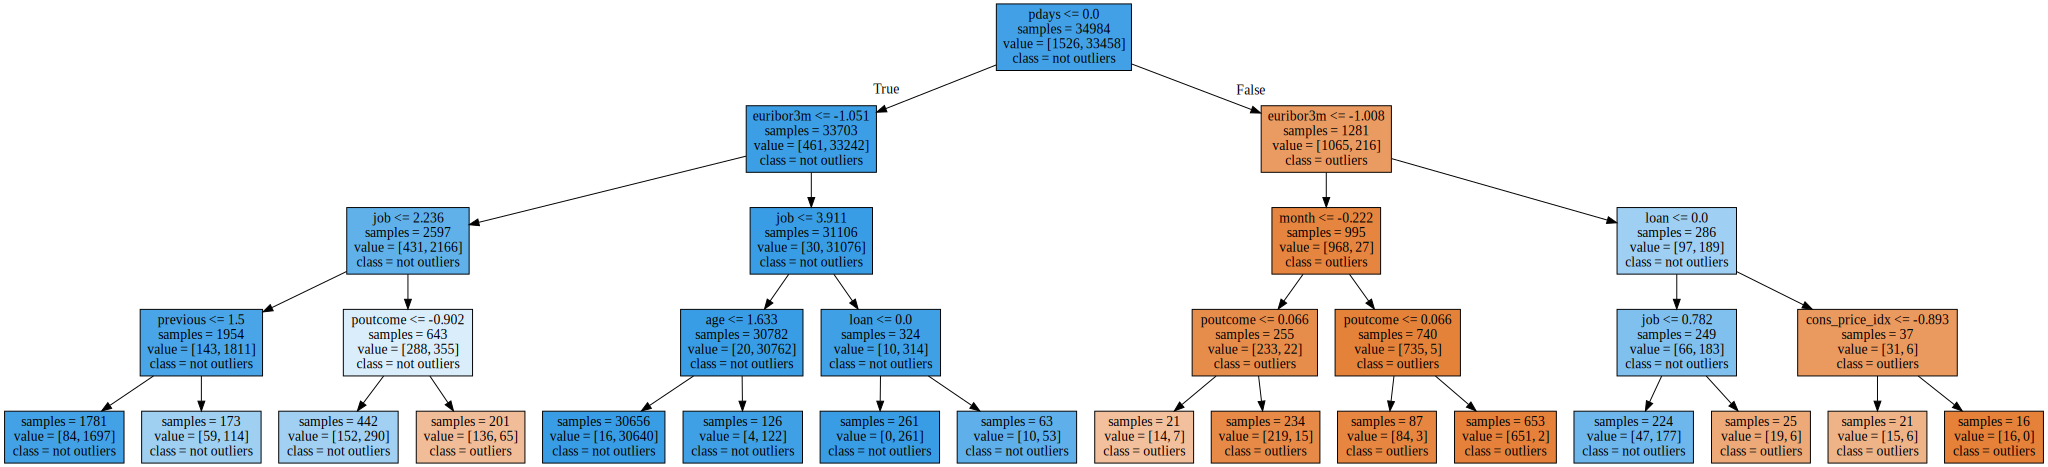

In [25]:
# чтобы лучше понимать, что делает выбросы выбросами визуализируем дерево решений
tree = DecisionTreeClassifier(random_state=0, max_depth=4)  
tree.fit(df_outliers.iloc[:,:-1], df_outliers.outliers)

dot_data = export_graphviz(tree, out_file='tree.dot', 
              feature_names = df_outliers.iloc[:,:-1].columns,
              class_names = ['outliers', 'not outliers'], 
              impurity=False, filled = True)

with open('tree.dot') as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

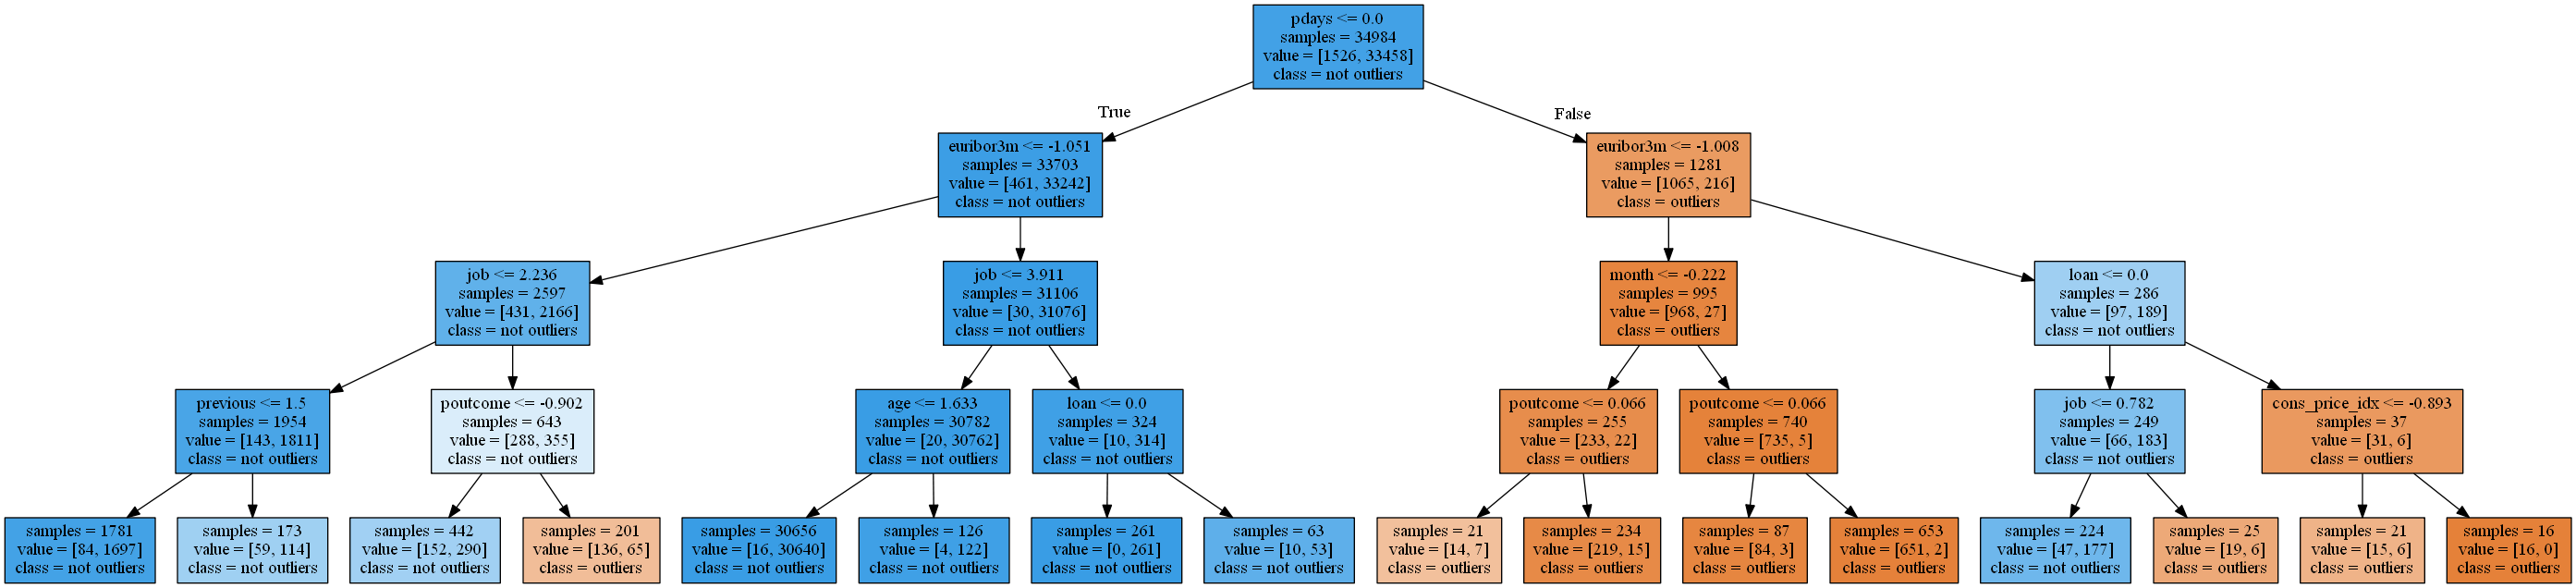

In [26]:
graph = pydotplus.graphviz.graph_from_dot_file('tree.dot')  
Image(graph.create_png())

In [28]:
# удаляем выбросы
train_eda.drop(list(anomaly_score[anomaly_score <= outlier_threshold].index), inplace=True)
df_NaN.drop(list(anomaly_score[anomaly_score <= outlier_threshold].index), inplace=True)

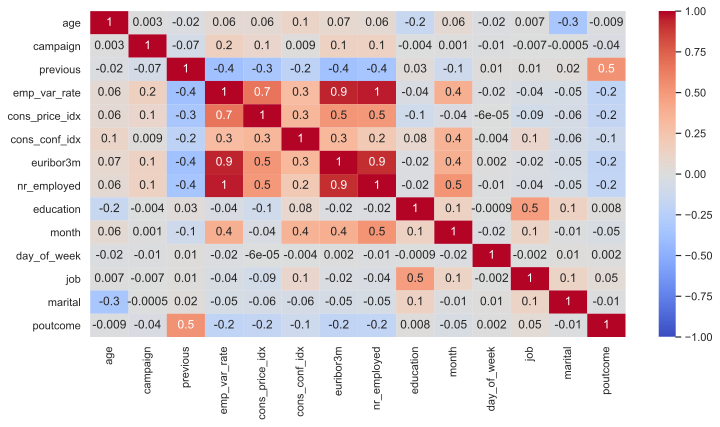

In [30]:
# смотрим на корреляцию Спирмена
spearman_corr = train_eda[quant_ord+nominal].corr(method='spearman') 
sns.set(rc={'figure.figsize':(12,6)})
sns.heatmap(spearman_corr, annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap= 'coolwarm')
plt.show()

In [31]:
# вычисляем коэффициент инфляции дисперсии (VIF)
calculate_vif(train_eda[quant_ord+nominal])

,variables,VIF
0,age,1.288844
1,campaign,1.033321
2,previous,1.597780
3,emp_var_rate,35.772005
4,cons_price_idx,6.571609
5,cons_conf_idx,2.947028
6,euribor3m,75.142787
7,nr_employed,32.431277
8,education,1.156557
9,month,1.598441


covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8


<AxesSubplot:>

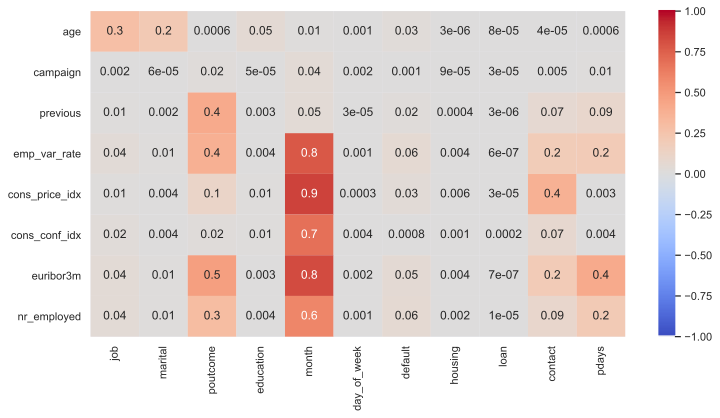

In [32]:
# вычисляем коэффициент eta для иземрения "корреляции" между количественными и категориальными признаками
quant_cat_corr = calculate_eta_corr(df_NaN, quantitative, cat)
sns.heatmap(quant_cat_corr, annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap= 'coolwarm')
# наблюдаем высокую корреляцию месяцев с месячными показателями


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


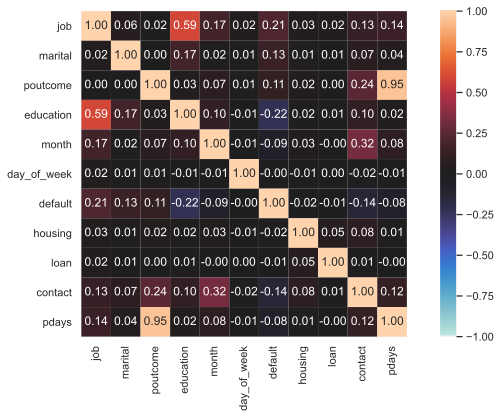

In [33]:
# вычисляем "корреляцию" между категориальными признакми, используя коэффицент неопределенности 
cat_cat_corr = associations(df_NaN[cat], theil_u=True)['corr']

In [34]:
# удаляем объекты с NaN для экономии времени,
# ввиду несовместимости работы GridSearch в паралельном режиме
# с MissForest и достаточно высоких временных затрат на заполнение пропусков MissForest,
# для осуществления предварительного быстрого выбора вариантов SMOTE и наборов признаков
# надеясь, что удаление небольшого процента данных не изменит ранг вариантов SMOTE
# по average_precision
train_dropna = pd.concat([X_train, y_train], axis=1)
train_dropna = train_dropna.dropna()
X_train_dropna =  train_dropna.loc[:, df_NaN.columns != 'y'] 
y_train_dropna = train_dropna.y

In [35]:
#получаем списки сильно коррелирующих функций
spearman_corr_features = get_high_corr_features(spearman_corr, 0.93) 
cat_cat_corr_features = get_high_corr_features(cat_cat_corr, 0.93)
quant_cat_corr_features =  get_high_corr_features(quant_cat_corr, 0.8, False)
all_corr_features = spearman_corr_features + cat_cat_corr_features + quant_cat_corr_features

# получаем индексы сильно коррелирующих признаков
spearman_corr_indexes = get_indexes_features(X_train_dropna, spearman_corr_features) 
cat_cat_corr_indexes = get_indexes_features(X_train_dropna, cat_cat_corr_features)
quant_cat_corr_indexes = get_indexes_features(X_train_dropna, quant_cat_corr_features)

# получаем индексы всех признаков без сильно коррелирующих
all_wo_corr_indexes = [X_train_dropna.columns.get_loc(column) for column 
                   in X_train_dropna.columns.difference(all_corr_features)]

# так как 'month' из quant_cat_corr_features коррелирует с 
# признаками 'emp_var_rate', 'euribor3m', 'nr_employed' из spearman_corr_features
# они входят в одну группу коррелирующих признаков
comb_group1 = get_all_combinations(spearman_corr_indexes + quant_cat_corr_indexes)
comb_group2 = get_all_combinations(cat_cat_corr_indexes)

# получаем список, состоящий из списков, каждый из которых
# состоит из индексов, среди которых есть хотя бы 1 индекс признака
# из каждой группы высоко коррелирующих признаков
# + индексы признаков, не входящие ни в одну из групп
corr_combinations = []
for comb1 in comb_group1:
    for comb2 in comb_group2:
        corr_combinations.append(comb1 + comb2 + all_wo_corr_indexes)

In [ ]:
# выбираем лучшие комбинации признаков
pipe_corr_col_selector = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),
    ('scaler', Scaler),
    ('column', ColumnSelector()),
    ('classifier', KNeighborsClassifier(n_jobs=-1))
    ])

param_grid_corr_col_selector = {
    'column__cols': corr_combinations, 
    'classifier': [KNeighborsClassifier(n_jobs=-1),
                   LogisticRegression(random_state=SEED)
                   LogisticRegression(random_state=SEED, C=100),
                   SVC(random_state=SEED), 
                   SVC(random_state=SEED, kernel = 'linear'),
                   LGBMClassifier(random_state=SEED), 
                   CatBoostClassifier(random_state=SEED), 
                   XGBClassifier(random_state=SEED), 
                   RandomForestClassifier(random_state=SEED, n_jobs=-1) 
                   ]
     }

SCORING = ['average_precision', 'roc_auc']

grid_corr_col_selector = GridSearchCV(pipe_corr_col_selector, param_grid_corr_col_selector, cv=5, 
                                      scoring=SCORING, refit='average_precision', n_jobs=-1, verbose=2) 
grid_corr_col_selector.fit(X_train_dropna, y_train_dropna)

get_grid_result(grid_corr_col_selector).to_excel('grid_corr_col_selector.xlsx')

In [37]:
# тюнить LGBMClassifier для Leshy будем на 
# лучшей по average precision комбинации признаков для 
# логистической регрессии, KNN, SVC с ядром rbf 
# из минимальных (когда в каждой коррелирующей группе остается по 1 признаку)
# для того, чтобы более точно оценить важность признаков
best_combination = [17, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]
best = [X_train_dropna.columns[i] for i in best_combination]
ord_bin_nan_index2 = [X_train[best].columns.get_loc(col) for col in ord_bin_nan]

pipe_lgbm_leshy = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('classifier', LGBMClassifier(random_state=SEED))
    ]) 

param_lgbm_leshy = {
    'classifier__learning_rate': optuna.distributions.UniformDistribution(0.005, 0.3),                   
    'classifier__num_leaves': optuna.distributions.IntUniformDistribution(7, 200),   
    'classifier__lambda_l2': optuna.distributions.IntUniformDistribution(0, 15),
    'classifier__min_data_in_leaf': optuna.distributions.IntUniformDistribution(5, 175),    
    'classifier__subsample': optuna.distributions.UniformDistribution(0.5 ,1.0),
    'classifier__colsample_bytree': optuna.distributions.UniformDistribution(0.7, 1.0),
    'classifier__scale_pos_weight': optuna.distributions.IntUniformDistribution(1, 33, 2)
    }
optuna_search_lgbm_leshy = optuna.integration.OptunaSearchCV(pipe_lgbm_leshy, 
                                                             param_lgbm_leshy,
                                                             n_trials=40, 
                                                             random_state=SEED, 
                                                             n_jobs=-1,
                                                             scoring='average_precision')
optuna_search_lgbm_leshy.fit(X_train[best], y_train, imputer__cat_vars=ord_bin_nan_index2)

optuna_search_lgbm_leshy.trials_dataframe().sort_values(['value'], ascending = False).to_excel("LGBM_for_Leshy.xlsx")

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


In [4]:
# используем лучшие гиперпараметры LGBMClassifier для Leshy

lgbm_leshy_best_params = optuna_search_LGBM_Leshy.best_params_
lgbm_leshy = LGBMClassifier(**lgbm_leshy_best_params)

feat_selector = arfsgroot.Leshy(lgbm_leshy, n_estimators=100, verbose=1, 
                                max_iter=100, random_state=SEED, importance='shap')
feat_selector.fit(X_train_eda[best], y_train)
# визуализируем важность признаков
print(feat_selector.support_names_)
feat_selector.plot_importance(n_feat_per_inch=3)

In [ ]:
# лучшие комбинации признаков по average_precision относительно коррелирующих признаков
best_comb_log_reg = [14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]
best_comb_svc = [17, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]
best_comb_knn = [17, 18, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]

# создаем список неважных признаков
unimportant_features = feat_selector.tag_df[feat_selector.tag_df.Boruta == 0].predictor.to_list()
unimportant_features_indexes = get_indexes_features(X_train_dropna, unimportant_features)
unimportant_features_indexes

# лучшие комбинации без неважных признаков
imp_comb_log_reg = [column for column in best_comb_log_reg 
                    if column not in unimportant_features_indexes]
imp_comb_svc = [column for column in best_comb_svc 
                if column not in unimportant_features_indexes]
imp_comb_knn = [column for column in best_comb_knn 
                if column not in unimportant_features_indexes]
unimp_combinations = all_combinations(unimportant_features_indexes, empty_combination = True)

imp_unimp_combs_log_reg = get_imp_unimp_combinations(unimp_combinations, imp_comb_log_reg)
imp_unimp_combs_svc = get_imp_unimp_combinations(unimp_combinations, imp_comb_svc)
imp_unimp_combs_knn = get_imp_unimp_combinations(unimp_combinations, imp_comb_knn)

In [ ]:
# выбираем лучшие комбинации для каждого из алгоритмов
pipe_imp_col_selector = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),
    ('scaler', Scaler),
    ('column', ColumnSelector()),
    ('classifier', KNeighborsClassifier(n_jobs=-1))
    ]) 

param_grid_imp_col_selector = [{'classifier': [KNeighborsClassifier(n_jobs=-1)],
                                'column__cols': imp_unimp_combs_knn},
                               {'classifier': [SVC(random_state=SEED)],
                                'column__cols': imp_unimp_combs_svc},
                               {'classifier': [LogisticRegression(random_state=SEED)],
                                'column__cols': imp_unimp_combs_log_reg}] 


grid_imp_col_selector = GridSearchCV(pipe_imp_col_selector, param_grid_imp_col_selector, cv=5, 
                                     scoring=SCORING, refit='average_precision', n_jobs=-1, verbose=2) 
grid_imp_col_selector.fit(X_train_dropna, y_train_dropna)

get_grid_result(grid_imp_col_selector).to_excel('grid_imp_col_selector.xlsx')
# лучшим для SVC является набор без 1 неважного признака
best_comb_SVC = (5, 6, 2, 17, 11, 0, 10, 16, 15, 7, 9, 4, 1, 12)
# лучшими наборами для KNN и log_reg являются наборы со всеми неважными признаками
best_comb_log_reg = (14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)
best_comb_KNN = (17, 18, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)

In [ ]:
# выбираем лучше удалять/не удалять выбросы из всей выборки или только отрицательного класса
pipe_reject_outliers = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)),
    ('scaler', Scaler),
    ('classifier', KNeighborsClassifier(n_jobs=-1))
    ]) 

param_grid_reject_outliers = {
    'classifier': [KNeighborsClassifier(n_jobs=-1),
                   LogisticRegression(random_state=SEED),
                   SVC(random_state=SEED)],
    'reject_outliers': [FunctionSampler(func=reject_neg_class_outliers),
                        FunctionSampler(func=reject_outliers)],
    'reject_outliers__kw_args': [{'contamination': con} for con 
                                 in [0.0, 0.01, 0.02, 0.04, 0.08, 0.1]]
    }                

grid_reject_outliers = GridSearchCV(pipe_reject_outliers, param_grid_reject_outliers, cv=5, 
                                    scoring=SCORING, refit='average_precision', n_jobs=-1, verbose=2) 
grid_reject_outliers.fit(X_train_dropna, y_train_dropna) 

get_grid_result(grid_reject_outliers).to_excel('grid_reject_outliers.xlsx')

In [ ]:
# смотрим с каким вариантом SMOTE average_precision будет максимальна
pipe_smote_log_svc = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),
    ('scaler', Scaler),
    ('smote', sv.LVQ_SMOTE(random_state=SEED, n_jobs = -1)),
    ('classifier', LogisticRegression(random_state=SEED))
    ]) 

param_grid_smote_log_svc = {
    'classifier':[LogisticRegression(random_state=SEED), SVC(random_state=SEED)], 
    'smote': [sv.LVQ_SMOTE(random_state=SEED, n_jobs=-1), 
              sv.polynom_fit_SMOTE(random_state=SEED), 
              sv.ProWSyn(random_state=SEED),
              sv.SMOTE_IPF(random_state=SEED, n_jobs=-1), 
              sv.SMOBD(random_state=SEED, n_jobs=-1),
              sv.G_SMOTE(random_state=SEED, n_jobs=-1),
              sv.Supervised_SMOTE(random_state=SEED, n_jobs=-1),
              sv.DBSMOTE(random_state=SEED, n_jobs=-1),
              sv.CURE_SMOTE(random_state=SEED, n_jobs=-1),
              sv.DE_oversampling(random_state=SEED, n_jobs=-1),
              sv.CCR(random_state=SEED, n_jobs=-1)
              sv.NoSMOTE(random_state=SEED)],
    'smote__proportion': [0.25, 0.75]
    }

grid_smote_log_svc = GridSearchCV(pipe_smote_log_svc, param_grid_smote_log_svc, cv=5, scoring=SCORING,
                                  refit='average_precision', n_jobs=-1, verbose=2) 
grid_smote_log_svc.fit(X_train_dropna, y_train_dropna)

get_grid_result(grid_smote_log_svc).to_excel('grid_smote_log_svc.xlsx')

In [ ]:
pipe_smote_svc = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),
    ('scaler', Scaler),
    ('smote', sv.CE_SMOTE(random_state=SEED, n_jobs = -1)),
    ('classifier', SVC(cache_size=1900))
    ])

param_grid_smote_svc = {'smote': [sv.CE_SMOTE(random_state=SEED, n_jobs=-1),
                        sv.SMOTE_ENN(random_state=SEED, n_jobs=-1),
                        sv.MDO(random_state=SEED, n_jobs=-1),                        
                        sv.SMOTE_Cosine(random_state=SEED, n_jobs=-1)],
                        'smote__proportion': [0.25, 0.75]}

grid_smote_svc = GridSearchCV(pipe_smote_svc, param_grid_smote_svc, cv=5, scoring=SCORING,
                              refit='average_precision', n_jobs=-1, verbose=2) 
grid_smote_svc.fit(X_train_dropna, y_train_dropna)

get_grid_result(grid_smote_svc).to_excel('grid_smote_svc.xlsx')

In [ ]:
pipe_smote_log = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),
    ('scaler', Scaler),
    ('smote', sv.Gaussian_SMOTE(random_state=SEED, n_jobs=-1)),
    ('classifier', LogisticRegression(random_state=SEED))
    ]) 

param_grid_smote_log = {'smote': [sv.Gaussian_SMOTE(random_state=SEED, n_jobs=-1),
                                  sv.NEATER(random_state=SEED, n_jobs=-1),
                                  sv.DE_oversampling(random_state=SEED, n_jobs=-1),
                                  sv.NoSMOTE(random_state=SEED)],
                        'smote__proportion': [0.25, 0.75]}

grid_smote_log = GridSearchCV(pipe_smote_log, param_grid_smote_log, cv= 5, scoring=SCORING,
                              refit='average_precision', n_jobs=-1, verbose=2) 
grid_smote_log.fit(X_train_dropna, y_train_dropna)

get_grid_result(grid_smote_log).to_excel('grid_smote_log.xlsx')

In [ ]:
pipe_smote_knn = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),                  
    ('scaler', Scaler),
    ('smote', sv.LVQ_SMOTE(random_state=SEED, n_jobs = -1)),
    ('classifier', KNeighborsClassifier(n_jobs=-1))
    ])

param_grid_smote_knn = {
    'smote': [sv.LVQ_SMOTE(random_state=SEED, n_jobs=-1), 
              sv.polynom_fit_SMOTE(random_state=SEED), 
              sv.ProWSyn(random_state=SEED),
              sv.SMOTE_IPF(random_state=SEED, n_jobs=-1), 
              sv.SMOBD(random_state=SEED, n_jobs=-1), 
              sv.G_SMOTE(random_state=SEED, n_jobs=-1),
              sv.Supervised_SMOTE(random_state=SEED, n_jobs=-1),
              sv.AHC(random_state=SEED),
              sv.Assembled_SMOTE(random_state=SEED, n_jobs=-1), 
              sv.CCR(random_state=SEED, n_jobs=-1), 
              sv.DE_oversampling(random_state=SEED, n_jobs=-1),
              sv.NoSMOTE(random_state=SEED), 
              sv.CE_SMOTE(random_state=SEED, n_jobs=-1),
              sv.LLE_SMOTE(random_state=SEED, n_jobs=-1),
              sv.Gaussian_SMOTE(random_state=SEED, n_jobs=-1),
              sv.Borderline_SMOTE1(random_state=SEED, n_jobs=-1),
              sv.SMOTE_ENN(random_state=SEED, n_jobs=-1),
              sv.SMOTE_TomekLinks(random_state=SEED, n_jobs=-1)],
    'smote__proportion': [0.25, 0.75]
    }

grid_smote_knn = GridSearchCV(pipe_knn, param_grid_smote_knn, cv=5, scoring=SCORING, 
                              refit='average_precision', n_jobs=-1, verbose=2) 
grid_smote_knn.fit(X_train_dropna, y_train_dropna)

get_grid_result(grid_smote_knn).to_excel('grid_smote_knn.xlsx')

In [ ]:
pipe_boost_rf = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),                  
    ('scaler', Scaler),
    ('smote', sv.LVQ_SMOTE(random_state=SEED, n_jobs = -1)),
    ('classifier', LGBMClassifier(random_state=SEED))
    ])

param_grid_boost_rf = {
    'classifier':[LGBMClassifier(random_state=SEED),
                  CatBoostClassifier(random_state=SEED),
                  XGBClassifier(random_state=SEED),
                  RandomForestClassifier(random_state=SEED, n_jobs=-1)], 
    'smote':[sv.LVQ_SMOTE(random_state=SEED, n_jobs=-1),
             sv.Borderline_SMOTE2(random_state=SEED, n_jobs=-1),
             sv.SMOBD(random_state=SEED, n_jobs=-1),
             sv.ProWSyn(random_state=SEED),             
             sv.polynom_fit_SMOTE(random_state=SEED),
             sv.DE_oversampling(random_state=SEED, n_jobs=-1),
             sv.NoSMOTE(random_state=SEED)], 
    'smote__proportion': [0.25, 0.75]
    } 

grid_boost_rf = GridSearchCV(pipe_boost_rf, param_grid_boost_rf, cv5, scoring=SCORING,
                             refit='average_precision', n_jobs=-1, verbose=2) 
grid_boost_rf.fit(X_train_dropna, y_train_dropna) 

get_grid_result(grid_boost_rf).to_excel('grid_boost_rf.xlsx')

In [ ]:
# далее тюним гиперпараметры для конечных моделей
# opt_comb - это индексы наборов признаков, среди которых
# один набор всегда все признаки датасета, другие  - лучшие наборы
# по average_precision по результатам предварительного тюнинга
opt_comb_log_reg = [[14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
                    [14, 17, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]] 

pipe_log_reg = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),                   
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),    
    ('classifier', LogisticRegression(random_state=SEED, n_jobs =-1))
    ]) 

param_log_reg = {
    'classifier__solver': optuna.distributions.CategoricalDistribution(['newton-cg', 'lbfgs', 
                                                                        'liblinear', 'sag', 
                                                                        'saga']),
    'classifier__C': optuna.distributions.LogUniformDistribution(1e-3, 1e3),
    'classifier__class_weight': optuna.distributions.CategoricalDistribution([{0: 1, 1: w} for w 
                                                                              in[1, 2, 4, 8, 12, 16, 24, 32]]),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution([{'contamination': con} for con 
                                                                              in [0.00, 0.01, 0.02, 0.03, 0.04]]),
    'column_selector__cols': optuna.distributions.CategoricalDistribution(opt_comb_log_reg)
    }
optuna_search_log_reg = optuna.integration.OptunaSearchCV(pipe_log_reg, param_log_reg, n_trials=2,
                                                          random_state=SEED, n_jobs=-1,
                                                          scoring='average_precision')
optuna_search_log_reg.fit(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes)

optuna_search_log_reg.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_log_reg.xlsx")
optuna_search_log_reg.best_params_

In [ ]:
# обучение svc было остановлено на 27 итерации из 60
# ввиду очень длительного времени обучения
opt_comb_svc = [[14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
                [17, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
                [5, 6, 2, 17, 11, 0, 10, 16, 15, 7, 9, 4, 1, 12]]

pipe_svc = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),                   
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),                
    ('smote', sv.SMOTE_ENN(random_state=SEED, n_jobs=-1)),                   
    ('classifier', SVC())
    ])

param_svc = {
    'classifier__kernel': optuna.distributions.CategoricalDistribution(['rbf', 'poly', 'sigmoid']),
    'classifier__gamma': optuna.distributions.LogUniformDistribution(1e-3, 1e3),
    'classifier__C': optuna.distributions.LogUniformDistribution(1e-3, 1e3),
    'classifier__class_weight': optuna.distributions.CategoricalDistribution([{0: 1, 1: w} for w
                                                                              in[1, 2, 4, 8, 12, 16, 24, 32]]),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution([{'contamination': con} for con
                                                                               in [0.00, 0.01, 0.02, 0.03, 0.04]]),
    'smote__proportion': optuna.distributions.UniformDistribution(0.1269, 1.5),    
    'smote__n_neighbors': optuna.distributions.IntUniformDistribution(3, 27, 2),
    'column_selector__cols': optuna.distributions.CategoricalDistribution(opt_comb_svc)
    }
optuna_search_svc = optuna.integration.OptunaSearchCV(pipe_svc, param_svc, n_trials=60,
                                                      random_state=SEED, n_jobs =-1,
                                                      scoring='average_precision')
optuna_search_svc.fit(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes)

optuna_search_svc.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_SVC.xlsx")
optuna_search_svc.best_params_

In [ ]:
opt_comb_knn = [[17, 18, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
                [14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]]

pipe_knn = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),                   
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),                
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),        
    ('classifier', KNeighborsClassifier(n_jobs=-1))
    ]) 

param_knn = {
    'classifier__n_neighbors': optuna.distributions.IntUniformDistribution(1, 31, 2),
    'classifier__p': optuna.distributions.IntUniformDistribution(1, 2),
    'classifier__weights': optuna.distributions.CategoricalDistribution(['uniform', 'distance']),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution(
        [{'contamination': con} for con in [0.00, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08]]),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution(
        [{'max_samples': maxs} for maxs in [128, 256, 512]]),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution(
        [{'n_estimators': 100}, {'n_estimators': 200}]),
    'smote__proportion': optuna.distributions.UniformDistribution(0.1269, 1.5),    
    'smote__topology': optuna.distributions.CategoricalDistribution(['star', 'mesh', 'poly_1', 
                                                                     'poly_2', 'poly_3']),
    'column_selector__cols': optuna.distributions.CategoricalDistribution(opt_comb_knn)
    }
optuna_search_knn = optuna.integration.OptunaSearchCV(pipe_knn, param_knn, n_trials=60,
                                                      random_state=SEED, n_job=-1,
                                                      scoring='average_precision')
optuna_search_knn.fit(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes)

optuna_search_knn.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_KNN.xlsx")
optuna_search_knn.best_params_

In [ ]:
opt_comb_rf = [[17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
               [14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]]

pipe_rf = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),                   
    ('classifier', RandomForestClassifier(random_state=SEED, n_jobs=-1))
    ])

param_rf = {
    "classifier__max_features": optuna.distributions.IntUniformDistribution(4, 8),
    "classifier__n_estimators": optuna.distributions.IntUniformDistribution(100, 600),
    "classifier__criterion": optuna.distributions.CategoricalDistribution(['gini', 'entropy']),
    "classifier__bootstrap": optuna.distributions.CategoricalDistribution([True, False]),
    "classifier__max_samples": optuna.distributions.UniformDistribution(0.2 ,1.0), 
    "classifier__min_samples_leaf": optuna.distributions.IntUniformDistribution(1, 8),
    "classifier__class_weight": optuna.distributions.CategoricalDistribution(
        [{0: 1, 1 : w} for w in[1, 2, 4, 8, 12, 16, 24, 32]]),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution(
        [{'contamination': con} for con in [0.0, 0.01, 0.02, 0.03, 0.04]]),    
    'smote__proportion': optuna.distributions.UniformDistribution(0.1269, 1.5),    
    'smote__topology': optuna.distributions.CategoricalDistribution(['star', 'mesh', 'poly_1',
                                                                     'poly_2', 'poly_3']),
    'column_selector__cols': optuna.distributions.CategoricalDistribution(opt_comb_rf)
    } 


optuna_search_rf = optuna.integration.OptunaSearchCV(pipe_rf, param_rf, n_trials=90,
                                                     random_state=SEED, n_jobs=-1,
                                                     scoring='average_precision')
optuna_search_rf.fit(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes)

optuna_search_rf.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_RF.xlsx")
optuna_search_rf.best_params_

In [ ]:
opt_comb_cat = [[14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
                [14, 17, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]]

pipe_cat = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),                   
    ('classifier', CatBoostClassifier(n_estimators=1000, random_state=SEED))
    ]) 

param_cat = {
    'classifier__learning_rate' : optuna.distributions.UniformDistribution(0.005, 0.2),                   
    'classifier__max_depth': optuna.distributions.IntUniformDistribution(3, 10),   
    'classifier__l2_leaf_reg': optuna.distributions.IntUniformDistribution(1, 30),
    'classifier__bagging_temperature': optuna.distributions.DiscreteUniformDistribution(0.2, 50, 0.2),
    'classifier__random_strength': optuna.distributions.DiscreteUniformDistribution(0.0, 10, 0.2),
    'classifier__rsm': optuna.distributions.UniformDistribution(0.7 ,1.0), 
    'classifier__scale_pos_weight': optuna.distributions.IntUniformDistribution(1, 33, 2),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution(
        [{'contamination': con} for con in [0.0, 0.01, 0.02, 0.03, 0.04]]),
    'smote__proportion': optuna.distributions.UniformDistribution(0.1269, 1.5),    
    'smote__topology': optuna.distributions.CategoricalDistribution(['star', 'mesh', 'poly_1',
                                                                     'poly_2', 'poly_3']),
    'column_selector__cols': optuna.distributions.CategoricalDistribution(opt_comb_cat)
    }
optuna_search_cat = optuna.integration.OptunaSearchCV(pipe_cat, param_cat, n_trials=90,
                                                      random_state=SEED, n_jobs=-1,
                                                      scoring='average_precision')
optuna_search_cat.fit(X_train, y_train, imputer__cat_vars = ord_bin_nan_indexes)    

optuna_search_cat.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_Cat.xlsx")
optuna_search_cat.best_params_

In [ ]:
# ниже визцализация гиперпараметров и average_precision 
plot_optimization_history(optuna_search_RF.study_)

In [ ]:
plot_param_importances(optuna_search_RF.study_, params=["classifier__max_features",
                                                        "classifier__n_estimators",
                                                        "classifier__criterion",
                                                        "classifier__bootstrap",
                                                        "classifier__max_samples",
                                                        "classifier__min_samples_leaf",
                                                        "classifier__class_weight", 
                                                        'smote__proportion',
                                                        'smote__n_neighbors',
                                                        'smote__n_clusters'])

In [ ]:
fig = plot_contour(optuna_search_RF.study_, params=['smote__proportion',
                                                    'smote__n_clusters',
                                                    'smote__n_neighbors',
                                                    'classifier__class_weight'])    
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000    
)

In [ ]:
plot_parallel_coordinate(optuna_search_RF.study_, params=['smote__proportion',
                                                          'smote__n_clusters',
                                                          'smote__n_neighbors',
                                                          'classifier__max_features'])

In [ ]:
opt_comb_lgbm = [[14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
            [14, 17, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]]

pipe_lgbm = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.LVQ_SMOTE(random_state=SEED, n_jobs=-1)),                   
    ('classifier', LGBMClassifier(n_estimators=1000, random_state=SEED))
    ]) 

param_lgbm = {
    'classifier__learning_rate': optuna.distributions.UniformDistribution(0.005, 0.2),                   
    'classifier__num_leaves': optuna.distributions.IntUniformDistribution(7, 200),   
    'classifier__lambda_l2': optuna.distributions.IntUniformDistribution(0, 15),
    'classifier__min_data_in_leaf': optuna.distributions.IntUniformDistribution(5, 175),    
    'classifier__subsample': optuna.distributions.UniformDistribution(0.5 ,1.0),
    'classifier__colsample_bytree': optuna.distributions.UniformDistribution(0.7, 1.0),
    'classifier__scale_pos_weight': optuna.distributions.IntUniformDistribution(1, 33, 2),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution(
        [{'contamination': con} for con in [0.0, 0.01, 0.02, 0.03, 0.04]]),
    'smote__proportion': optuna.distributions.UniformDistribution(0.1269, 1.5),
    'smote__n_neighbors': optuna.distributions.IntUniformDistribution(3, 11, 2),
    'smote__n_clusters': optuna.distributions.IntUniformDistribution(3, 17),
    'column_selector__cols': optuna.distributions.CategoricalDistribution(opt_comb_lgbm)    
    }

%time optuna_search_lgbm = optuna.integration.OptunaSearchCV(pipe_lgbm, param_lgbm, n_trials=90,
                                                             random_state=SEED, n_jobs=-1,
                                                             scoring= 'average_precision')
optuna_search_lgbm.fit(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes) 

optuna_search_lgbm.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_LGBM.xlsx")
optuna_search_lgbm.best_params_

In [ ]:
opt_comb_xgb = [[14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
                [17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]]

pipe_xgb = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),                   
    ('classifier', XGBClassifier(n_estimators=1000, random_state=SEED))
    ])           

param_xgb = {
    'classifier__learning_rate' : optuna.distributions.UniformDistribution(0.005, 0.2),                   
    'classifier__max_depth': optuna.distributions.IntUniformDistribution(3, 10),   
    'classifier__lambda': optuna.distributions.IntUniformDistribution(0, 15),
    'classifier__min_child_weight': optuna.distributions.UniformDistribution(0.5, 40),    
    'classifier__subsample': optuna.distributions.UniformDistribution(0.5 ,1.0),
    'classifier__colsample_bytree': optuna.distributions.UniformDistribution(0.7, 1.0),
    'classifier__scale_pos_weight': optuna.distributions.IntUniformDistribution(1, 33, 2),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution(
        [{'contamination': con} for con in [0.0, 0.01, 0.02, 0.03, 0.04]]),        
    'smote__proportion': optuna.distributions.UniformDistribution(0.1269, 1.5),    
    'smote__topology': optuna.distributions.CategoricalDistribution(['star', 'mesh', 'poly_1', 
                                                                     'poly_2', 'poly_3']),
    'column_selector__cols': optuna.distributions.CategoricalDistribution(opt_comb_xgb)
    }

optuna_search_xgb = optuna.integration.OptunaSearchCV(pipe_xgb, param_xgb, n_trials=90,
                                                      random_state=SEED, n_jobs=-1, 
                                                      scoring= 'average_precision')
%time optuna_search_xgb.fit(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes)

optuna_search_xgb.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_XGB.xlsx")
optuna_search_xgb.best_params_

In [20]:
# все пайплайны и лучшие параметры для каждого пайплайна
pipe_log_reg = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),                   
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),    
    ('classifier', LogisticRegression(random_state=SEED, n_jobs =-1))
    ]) 

pipe_svc = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),                   
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),                
    ('smote', sv.SMOTE_ENN(random_state=SEED, n_jobs=-1)),                   
    ('classifier', SVC())
    ])

pipe_knn = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),                   
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),                
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),        
    ('classifier', KNeighborsClassifier(n_jobs=-1))
    ])

pipe_rf = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),                   
    ('classifier', RandomForestClassifier(random_state=SEED, n_jobs=-1))
    ])

pipe_cat = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),                   
    ('classifier', CatBoostClassifier(n_estimators=1000, random_state=SEED))
    ]) 

pipe_lgbm = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.LVQ_SMOTE(random_state=SEED, n_jobs=-1)),                   
    ('classifier', LGBMClassifier(n_estimators=1000, random_state=SEED))
    ]) 

pipe_xgb = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),                   
    ('classifier', XGBClassifier(n_estimators=1000, random_state=SEED))
    ])  

log_reg = {'classifier__C': 0.209261731596304,
'classifier__class_weight':{0: 1, 1: 1},
'classifier__solver': 'liblinear',
'column_selector__cols': (14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12),
'reject_outliers__kw_args':{'contamination': 0.02}}

# обучение svc было остановлено на 27 итерации из 60
# ввиду очень длительного времени обучения
# это лучшие параметры по итогу 27 итераций
svc = {'classifier__kernel': 'poly', 
'classifier__gamma': 9.177188150921296, 
'classifier__C': 0.0035624340456710474, 
'classifier__class_weight': {0: 1, 1: 4}, 
'reject_outliers__kw_args': {'contamination': 0.03}, 
'smote__proportion': 0.33547381102012774, 
'smote__n_neighbors': 5, 
'column_selector__cols': (17, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)}


knn = {'classifier__n_neighbors': 31,
 'classifier__p': 1,
 'classifier__weights': 'uniform',
 'reject_outliers__kw_args': {'n_estimators': 100},
 'smote__proportion': 0.6854375019617758,
 'smote__topology': 'poly_1',
 'column_selector__cols': (17, 18, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)}


rf = {'classifier__max_features': 5,
 'classifier__n_estimators': 568,
 'classifier__criterion': 'gini',
 'classifier__bootstrap': True,
 'classifier__max_samples': 0.3763813382878065,
 'classifier__min_samples_leaf': 5,
 'classifier__class_weight': {0: 1, 1: 24},
 'reject_outliers__kw_args': {'contamination': 0.01},
 'smote__proportion': 0.36660330414955,
 'smote__topology': 'poly_2',
 'column_selector__cols': (17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)}


cat = {'classifier__learning_rate': 0.03881187434659765,
 'classifier__max_depth': 3,
 'classifier__l2_leaf_reg': 25,
 'classifier__bagging_temperature': 31.400000000000002,
 'classifier__random_strength': 3.8000000000000003,
 'classifier__rsm': 0.734519866165844,
 'classifier__scale_pos_weight': 3,
 'reject_outliers__kw_args': {'contamination': 0.0},
 'smote__proportion': 0.1333872731877877,
 'smote__topology': 'star',
 'column_selector__cols': (14, 17, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)}


lgbm = {'classifier__learning_rate': 0.01358112662653318,
 'classifier__num_leaves': 35,
 'classifier__lambda_l2': 4,
 'classifier__min_data_in_leaf': 35,
 'classifier__subsample': 0.5403335513789371,
 'classifier__colsample_bytree': 0.701372960674491,
 'classifier__scale_pos_weight': 29,
 'reject_outliers__kw_args': {'contamination': 0.01},
 'smote__proportion': 1.0837182125082963,
 'smote__n_neighbors': 11,
 'smote__n_clusters': 15,
 'column_selector__cols': (14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)}


xgb = {'classifier__learning_rate': 0.02127968419934923,
 'classifier__max_depth': 3,
 'classifier__lambda': 11,
 'classifier__min_child_weight': 18.721004255101306,
 'classifier__subsample': 0.9492285431239548,
 'classifier__colsample_bytree': 0.958879066205903,
 'classifier__scale_pos_weight': 11,
 'reject_outliers__kw_args': {'contamination': 0.0},
 'smote__proportion': 1.45813336459613,
 'smote__topology': 'poly_3',
 'column_selector__cols': (17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)}

pipelines = [pipe_log_reg, pipe_knn, pipe_rf, pipe_cat, pipe_lgbm, pipe_xgb]
parameters = [log_reg, knn, rf, cat, lgbm, xgb]
classifier_names = ['log_reg', 'knn', 'rf', 'cat', 'lgbm', 'xgb']

In [ ]:
# обучаем модели с лучшими параметрами для рассчета average precision
# и построения в дальнейшим графиков Precision Recall кривых
test_precision = []
test_recall  = []
test_ap = []

for pipeline, parameter in zip (pipelines, parameters):             
    pipeline.set_params(**parameter)
    pipeline.fit(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes)    
    
    y_proba = pipeline.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)    
    ap = average_precision_score(y_test, y_proba)
        
    test_precision.append(precision)
    test_recall.append(recall)
    test_ap.append(ap)

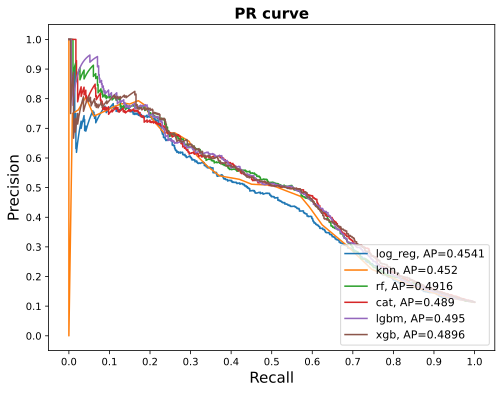

In [22]:
# строим Precision Recall кривые
fig = plt.figure(figsize=(8,6))

for i in range(len(test_recall)):
    plt.plot(test_recall[i],
             test_precision[i],
             label="{}, AP={}".format(str(classifier_names[i]), round(test_ap[i], 4)))

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Recall", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Precision", fontsize=15)

plt.title('PR curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size':11}, loc='lower right')

plt.show()


In [ ]:
# проводим повторную кросс-валидацию 5 раз с разными random seed
# для разбиения данных (RepeatedStratifiedKFold) для получения более надежных оценок

n_splits = 5
n_repeats = 5
number_models = n_splits * n_repeats
clf_name_list = []
cv_ap_list = []
cv_std_ap = []
cv_mean_ap = []
cv_name_mean_std = []

for pipeline, clf_name in zip(pipelines, classifier_names):    
    
    kfold = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=SEED)
    cv_average_precision_array = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='average_precision')    
    clf_name_list.extend([clf_name] * number_models)
    cv_ap_list.extend(cv_average_precision_array.tolist())
    
    cv_std_ap.append(np.std(cv_average_precision_array))
    cv_mean_ap.append(np.mean(cv_average_precision_array))
    cv_name_mean_std.append((clf_name, np.mean(cv_average_precision_array), np.std(cv_average_precision_array)))
    
df_clf_ap = pd.DataFrame({'name_clf': clf_name_list, 'average_precision': cv_ap_list})
df_name_mean_std = pd.DataFrame(cv_name_mean_std, columns=['name', 'mean', 'std'])

box_cv_ap = sns.boxplot(x='name_clf', y='average_precision', data=df_clf_ap) 

In [27]:
df_name_mean_std

,name,mean,std
0,log_reg,0.435120,0.014038
1,knn,0.427750,0.015810
2,rf,0.464072,0.014424
3,cat,0.465590,0.014567
4,lgbm,0.463170,0.015388
5,xgb,0.466258,0.014847


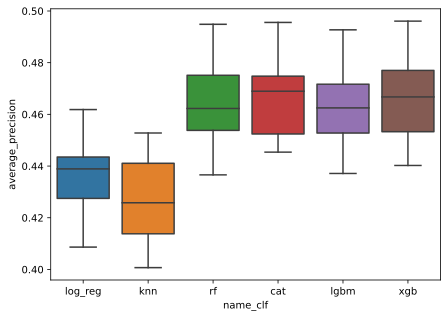

In [26]:
fig = plt.figure(figsize=(7,5)) 
box_cv_ap = sns.boxplot(x='name_clf', y='average_precision', data=df_clf_ap) 